In [2]:
import openbabel
import pybel
from pybel import ob
import GPy
import GPyOpt
import numpy as np
import pandas as pd
import math
import sys 
import os
import random
import matplotlib.pyplot as plt


In [3]:
# Biphenyl Example
biphenyl = pybel.readfile("sdf", os.getcwd() + "/molecules/biphenyl.sdf").next()

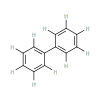

In [4]:
# Print Mol
biphenyl

In [5]:
# Force Field: MMFF94
ff = pybel._forcefields['mmff94']

def energy():
    return ff.Energy(False)

In [6]:
x = np.linspace(0,2*math.pi, 200).reshape([200,1])

rl = ob.OBRotorList()
rl.Setup(biphenyl.OBMol)
dimensions = rl.Size()

ff.Setup(biphenyl.OBMol)
currentCoords = biphenyl.OBMol.GetCoordinates()
rotIterator = rl.BeginRotors()
rotor = rl.BeginRotor(rotIterator)  # first rotatable bond
rotors = []
angles = []  # in radians
while rotor is not None:
    angle = rotor.CalcTorsion(currentCoords)
    angles.append(angle)
    rotors.append(rotor)
    rotor = rl.NextRotor(rotIterator)

def calculate_energy(torsion_angles):
    ff = pybel._forcefields['mmff94']
    output = []
    for j in range(torsion_angles.shape[0]):
        for i in range(torsion_angles.shape[1]):
            rotors[i].SetToAngle(currentCoords, torsion_angles[j,i])
            biphenyl.OBMol.SetCoordinates(currentCoords)
            ff.SetCoordinates(biphenyl.OBMol)
        output.append(ff.Energy())
    return np.array(output).reshape([torsion_angles.shape[0],1])

biphenyl_energy = calculate_energy(x)

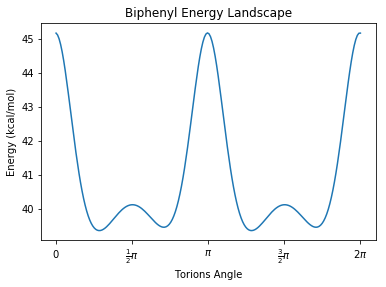

In [7]:
# Plot -- Simulated Energy Landscape 
plt.plot(x, biphenyl_energy)
plt.xticks([0, math.pi/2, math.pi, 3*math.pi/2, 2*math.pi],
           ["$0$", r"$\frac{1}{2}\pi$", r"$\pi$", r"$\frac{3}{2}\pi$", r"$2\pi$"])
plt.ylabel("Energy (kcal/mol)")
plt.xlabel("Torions Angle")
plt.title("Biphenyl Energy Landscape")
plt.show()

In [8]:
# Property of molecule
rl = ob.OBRotorList()

rl.Setup(biphenyl.OBMol)
rl.Size() # Number of rotatable bonds

1

In [9]:
# Bayesian Optimization
# Set Budget

design_domain = [{'name': 'torsion_{}'.format(x), 'type': 'continuous', 'domain': (0, 2*math.pi)} for x in range(dimensions)]
periodic = GPy.kern.StdPeriodic(input_dim=dimensions, period = 2, variance = 1)
rbfs = GPy.kern.RBF(input_dim=dimensions, variance = 1)
locally_periodic = GPy.kern.Prod([periodic,rbfs])

model = GPyOpt.models.GPModel(kernel= locally_periodic, exact_feval=True,optimize_restarts=10,verbose= False)
objective = GPyOpt.core.task.SingleObjective(calculate_energy)
space = GPyOpt.Design_space(design_domain)
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)
initial_design = GPyOpt.experiment_design.initial_design('random', space, 5)

acquisition_EI = GPyOpt.acquisitions.AcquisitionEI(model, space, optimizer=aquisition_optimizer)
evaluator_EI = GPyOpt.core.evaluators.Sequential(acquisition_EI)
EI_bo = GPyOpt.methods.ModularBayesianOptimization(model, space, objective, acquisition_EI, evaluator_EI, initial_design, normalize_Y=True)

source_out = os.getcwd() + "/molecules"

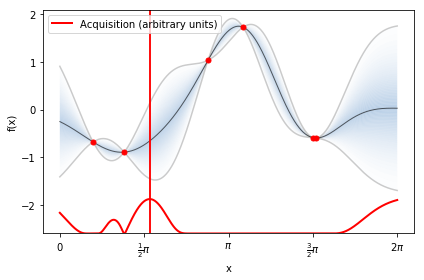

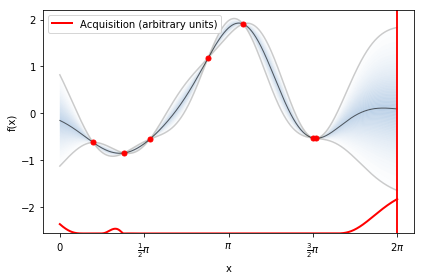

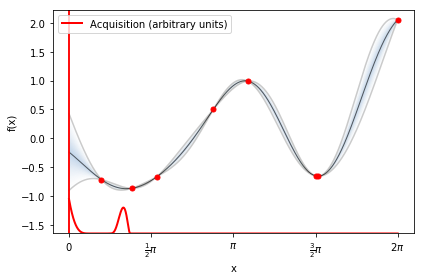

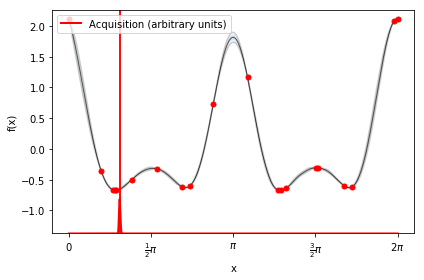

In [18]:
iterations = [1,2,3,15] 
for iters in iterations:
    np.random.seed(111)
    EI_bo = GPyOpt.methods.ModularBayesianOptimization(model, space, objective, acquisition_EI, evaluator_EI, initial_design, normalize_Y=True)
    EI_bo.run_optimization(max_iter = iters)
    EI_bo.plot_acquisition(filename=os.path.join(source_out, "step_{}.pdf".format(iters)))
    del EI_bo